
# 02 · ViT for Automotive Classification (GTSRB & Stanford Cars)

This notebook fine‑tunes a Vision Transformer for:
- **Traffic sign classification** on **GTSRB**.
- **Car model classification** on **Stanford Cars**.
It also includes **attention visualization** (rollout) to highlight discriminative regions.


In [ ]:

# (Optional) Install deps in Colab or a fresh environment.
# !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install -U transformers timm datasets accelerate evaluate scikit-learn albumentations matplotlib opencv-python


In [22]:

import os, random, math, time, numpy as np, torch
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import StanfordCars
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

from transformers import ViTForImageClassification, AutoImageProcessor
from transformers import set_seed

from transformers import set_seed
set_seed(42)

device = torch.device("cpu") 
import torch
torch.set_num_threads(4)      # tune: try 4–8 based on your CPU cores
print("Device:", device, "| threads:", torch.get_num_threads())


PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
DATA_ROOT.mkdir(parents=True, exist_ok=True)


Device: cpu | threads: 4


## Dataset & Transforms

In [12]:
from torch.utils.data import Subset
import numpy as np
# Use HF image processor to ensure ViT-compatible preprocessing
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Torchvision datasets
train_tf = transforms.Compose([transforms.Resize((224,224))])
test_tf  = transforms.Compose([transforms.Resize((224,224))])

gtsrb_train = datasets.GTSRB(root=str(DATA_ROOT), split="train", download=True, transform=train_tf)
gtsrb_test  = datasets.GTSRB(root=str(DATA_ROOT), split="test",  download=True, transform=test_tf)

np.random.seed(42)
train_idx = np.random.choice(len(gtsrb_train), size=min(5000, len(gtsrb_train)), replace=False)
test_idx  = np.random.choice(len(gtsrb_test),  size=min(1000, len(gtsrb_test)),  replace=False)

gtsrb_train = Subset(gtsrb_train, train_idx)
gtsrb_test  = Subset(gtsrb_test,  test_idx)

print("Train subset:", len(gtsrb_train), "| Test subset:", len(gtsrb_test))

# GTSRB has 43 traffic sign classes
NUM_GTSRB_CLASSES = 43
id2label_gtsrb = {i: str(i) for i in range(NUM_GTSRB_CLASSES)}
label2id_gtsrb = {v: k for k, v in id2label_gtsrb.items()}
num_labels_gtsrb = NUM_GTSRB_CLASSES



print("GTSRB classes:", num_labels_gtsrb)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Train subset: 5000 | Test subset: 1000
GTSRB classes: 43


In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32  # smaller batch fits CPU cache better

train_loader = DataLoader(
    gtsrb_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,           # Windows/Jupyter: keep 0
    collate_fn=collate_vit
)

test_loader = DataLoader(
    gtsrb_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_vit
)

# (Optional sanity check)
batch = next(iter(train_loader))
print({k: (tuple(v.shape) if hasattr(v, "shape") else type(v)) for k, v in batch.items()})




{'pixel_values': (32, 3, 224, 224), 'labels': (32,)}


## Model: ViT (HuggingFace)

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# MUCH smaller & faster on CPU than ViT-Base:
MODEL_NAME = "facebook/deit-tiny-patch16-224"  # DeiT-Tiny

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels_gtsrb,
    id2label=id2label_gtsrb,
    label2id=label2id_gtsrb,
    ignore_mismatched_sizes=True
).to(device)

# (Speed-up) Freeze backbone; train only classifier head on CPU
for name, p in model.named_parameters():
    if "classifier" not in name and "score" not in name:
        p.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=5e-4, weight_decay=0.0)




Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([43, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01 | train loss 2.7150 acc 0.3220 | test loss 2.2104 acc 0.4170
Epoch 02 | train loss 1.8527 acc 0.5336 | test loss 1.8227 acc 0.4790


## Training Loop (few epochs)

In [15]:

def train_one_epoch(model, loader):
    model.train()
    total, correct, running_loss = 0, 0, 0.0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad(set_to_none=True)
        out = model(**batch)
        loss = out.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch["labels"].size(0)
        preds = out.logits.argmax(dim=-1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss
        running_loss += loss.item() * batch["labels"].size(0)
        preds = out.logits.argmax(dim=-1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
    return running_loss/total, correct/total
EPOCHS = 2  # keep short on CPU for now
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)
    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")




Epoch 01 | train loss 1.5126 acc 0.6062 | test loss 1.6402 acc 0.5310
Epoch 02 | train loss 1.3184 acc 0.6496 | test loss 1.5359 acc 0.5490


## Save fine‑tuned checkpoint

In [16]:

ckpt_dir = PROJECT_ROOT / "checkpoints" / "vit_gtsrb"
ckpt_dir.mkdir(parents=True, exist_ok=True)
model.save_pretrained(ckpt_dir)
processor.save_pretrained(ckpt_dir)
print("Saved to:", ckpt_dir)


Saved to: C:\Projects\vision-transformers-automotive\checkpoints\vit_gtsrb


## Attention Visualization (Rollout)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


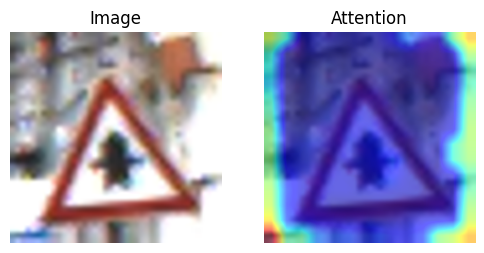

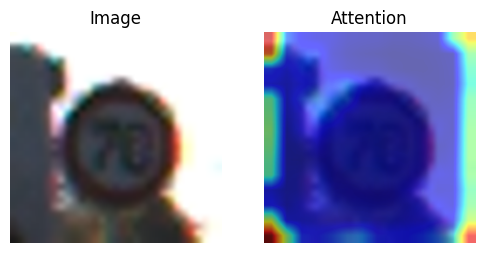

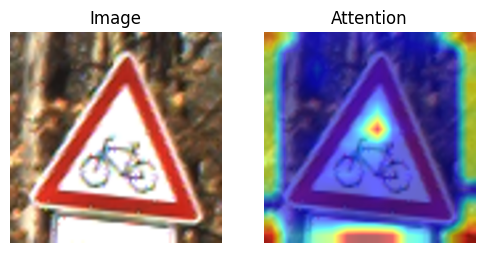

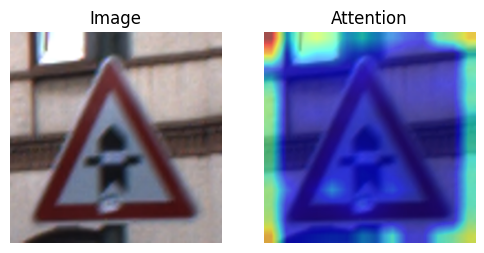

In [18]:

import sys
sys.path.append(str(PROJECT_ROOT))

import torch
from src.viz.attention_rollout import attention_rollout

@torch.no_grad()
def get_attn_rollout(model, images, discard_ratio=0.9):
    # forward with attentions
    out = model(pixel_values=images.to(device), output_attentions=True)
    atts = [a.detach().cpu() for a in out.attentions]  # list of (B, heads, T, T)
    rollout = attention_rollout(atts, discard_ratio=discard_ratio)  # (B, T, T)
    return rollout

def show_attention_on_image(pil_img, attn_rollout, patch_size=16):
    import numpy as np, cv2
    img = np.array(pil_img.resize((224,224)))
    H, W = 224, 224
    tokens = int((H//patch_size)*(W//patch_size) + 1)  # +1 for CLS
    # take CLS attention to patches
    cls_to_patches = attn_rollout[0, 0, 1:]  # (num_patches,)
    grid = int(math.sqrt(cls_to_patches.numel()))
    attn_map = cls_to_patches.view(grid, grid).numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)
    attn_map = cv2.resize(attn_map, (W, H))
    heat = (plt.cm.jet(attn_map)[..., :3] * 255).astype("uint8")
    overlay = (0.6*heat + 0.4*img).astype("uint8")
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Attention"); plt.imshow(overlay); plt.axis("off")
    plt.show()

# --- Attention demo that works with Subset and any torchvision version ---

from torchvision import datasets
from PIL import Image

# 1) Build a raw (no-transform) copy of the test dataset
gtsrb_test_raw = datasets.GTSRB(root=str(DATA_ROOT), split="test", download=True, transform=None)

# 2) Pick a few indices to visualize
if hasattr(gtsrb_test, "indices"):   # when you wrapped with Subset(...)
    demo_indices = gtsrb_test.indices[:4]  # take the first 4 from your subset
else:
    demo_indices = list(range(4))          # fallback: first 4 items

# 3) Collect PIL images (no transforms) for visualization
pil_imgs = [gtsrb_test_raw[i][0] for i in demo_indices]  # [ (PIL.Image, label) ][0] -> image

# 4) Encode with the same processor used for the model
enc = processor(images=pil_imgs, return_tensors="pt")

# 5) Compute rollout attention and display
roll = get_attn_rollout(model, enc["pixel_values"], discard_ratio=0.8)
for i, pil in enumerate(pil_imgs):
    show_attention_on_image(pil, roll[i].unsqueeze(0))



---
## (Optional) Stanford Cars classification

In [23]:

try:
    cars_train = datasets.StanfordCars(root=str(DATA_ROOT), split="train", download=True, transform=train_tf)
    cars_test  = datasets.StanfordCars(root=str(DATA_ROOT), split="test",  download=True, transform=test_tf)
    num_labels_cars = len(cars_train.classes)
    id2label_cars = {i: c for i, c in enumerate(cars_train.classes)}
    label2id_cars = {c: i for i, c in id2label_cars.items()}
    print("Stanford Cars classes:", num_labels_cars)
except Exception as e:
    print("Stanford Cars download failed in this environment (ok on your machine):", e)


Stanford Cars download failed in this environment (ok on your machine): The original URL is broken so the StanfordCars dataset cannot be downloaded anymore.



> Tip: Repeat the same training loop with `cars_train`/`cars_test` by creating new loaders and re‑initializing the ViT head with `num_labels_cars`.
